## Table of Contents
- [Introduction](#Introduction)
- [1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
  - [1.1 Preliminary Visualizations](#1.1-Preliminary-Visualizations)
  - [1.2 Data Cleaning](#1.2-Data-Cleaning)
  - [1.3 Basic Statistical Analysis](#1.3-Basic-Statistical-Analysis)
  - [1.4 Data Dictionary](#1.4-Data-Dictionary)
- [2. Preprocessing](#1.-Preprocessing)
  - [2.1 Train and Test Split](#2.1-Train-and-Test-Split)
  - [2.2 Define Text Cleaning and CountVectorizer Pipeline](#2.2-Define-Text-Cleaning-and-CountVectorizer-Pipeline)
  - [2.3 Apply CountVectorizer Pipeline to Data](#2.3-Apply-CountVectorizer-Pipeline-to-Data)
- [3. Modelling](#3.-Modelling)
  - [3.1 Logistic Regression Classifier](#Logistic-Regression-Classifier)
     - [3.1.1 Construct Logistic Regression Pipeline](#Construct-Logistic-Regression-Pipeline)
     - [3.1.2 Fit and Evaluate Logistic Regression Model](#3.1.2-Fit-and-Evaluate-Logistic-Regression-Model)
  - [3.2 Decision Tree Classifier](#3.2-Decision-Tree-Classifier)

# Introduction

INSERT INTRO PARAGRAPH HERE

In [1]:
# Import required libraries
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe' # Avoids plotly rendering issues
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

import itertools
import time

In [2]:
# Check plotly and notebook version for compatability issues

import plotly
import notebook

print("Plotly version:", plotly.__version__)
print("Jupyter Notebook version:", notebook.__version__)

Plotly version: 5.9.0
Jupyter Notebook version: 7.4.3


In [2]:
# Set figure size throughout notebook
plt.rcParams["figure.figsize"] = (8.0, 6.0)

In [3]:
# Load data

hotel_df = pd.read_csv("C:/Users/emshe/Desktop/BRAINSTATION/PYTHON_MATERIALS/TEST_DATA/Hotel_Reviews.csv")

og_hotel_df = hotel_df.copy() # Store original dataframe 

### Helper Functions

In [4]:
# Define function to examine dataframes

def examine_df(df):
   
    """
    Check basic info about a dataframe df
    """
    
    print(f"\n\nNumber of records is: {len(df)}\n")
    print(f"The columns are: {df.columns}\n")
    print(f"\n General info:")
    display(df.info())
    print(f"\n Statistical info:")
    display(df.describe())
    print(f"\n\nSample of records:")
    display(df.head(5))

In [5]:
# Define function to generate correlation heatmap for numeric columns of dataframe

def gen_corr_heatmap(df):

    """
    Generate correlation heatmap for numeric columns of a dataframe with plotly
    """
    
    num_df = df.select_dtypes(include='number')  # Restrict to numeric columns
    corr_matrix = num_df.corr()  # Compute correlation matrix

    fig = px.imshow(
        corr_matrix,
        text_auto=".2f",  # Show only two decimal points
        color_continuous_scale='RdBu',
        aspect='auto',
        title='Correlation Heatmap of Numeric Columns'
    )

    fig.update_layout(
        title={'x': 0.5},
        width=1000,  # Increase figure width
        height=1000,  # Increase figure height
        font=dict(size=8),  # Smaller font
        xaxis=dict(tickangle=45),  # Slant x-axis labels
        yaxis=dict(tickangle=0),   # Keep y-axis labels horizontal
    )

    fig.show()

In [6]:
# Define function to plot scatter plots comparing numeric columns in a dataframe

def scatter_matrix(df, sample_size=1000):

    """
    Generate scatter plots comparing pairs of numeric columns (with samples of records to avoid overplotting) 
    """
    
    num_df = df.select_dtypes(include='number').copy()
    sample_size = min(sample_size, len(num_df))
    num_df = num_df.sample(n=sample_size, random_state=2025)

    # Generate all unique (x, y) pairs
    cols = num_df.columns
    pairs = list(itertools.combinations(cols, 2))

    # Set up figure
    fig, axes = plt.subplots(7, 4, figsize=(20, 28))  # 7 rows × 4 cols = 28 subplots
    axes = axes.flatten()

    for i, (x, y) in enumerate(pairs):
        ax = axes[i]
        ax.scatter(num_df[x], num_df[y], s=5, alpha=0.5)
        ax.set_title(f'{x} vs {y}', fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=7)

    # Turn off any unused subplots (in case of fewer than 28 pairs)
    for j in range(len(pairs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [7]:
# Define function to plot probabilities of target variable vs. some feature's distribution

def plot_pos_probability(df, feature, target='Reviewer_Score', sample_size=10000, bins=30):

    """
    Generate plot of probability of target variable vs. some feature's distributiono
    """

    
    df = df[[feature, target]].dropna()
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=2025)

    # Bin the feature
    df['bin'], bin_edges = pd.cut(df[feature], bins=bins, retbins=True, labels=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Group by bin and compute conditional probability
    prob_by_bin = df.groupby('bin')[target].agg(['mean', 'count']).reset_index()
    prob_by_bin['bin_center'] = bin_centers[prob_by_bin['bin']]

    # Filter out bins with very low count for stability (optional)
    prob_by_bin = prob_by_bin[prob_by_bin['count'] >= 10]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(prob_by_bin['bin_center'], prob_by_bin['mean'], marker='o')
    plt.ylim(-0.05, 1.05)
    plt.title(f'Estimated P(Reviewer_Score = 1 | {feature})')
    plt.xlabel(feature)
    plt.ylabel('Probability of Positive Review')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 1. Exploratory Data Analysis

Perform EDA on the data and mention 3-4 observations from which you can draw actionable insights. In your EDA, you may consider creating a data dictionary, basic statistical analysis, data visualizations, data cleaning and preprocessing to prepare the data for modeling.

In [23]:
# Examine our hotel dataframe
examine_df(hotel_df)



Number of records is: 515738

The columns are: Index(['Average_Score', 'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'Latitude', 'Longitude', 'Reviewer_Nationality_Australia',
       'Reviewer_Nationality_Ireland', 'Reviewer_Nationality_UAE',
       'Reviewer_Nationality_UK', 'Reviewer_Nationality_USA',
       'Reviewer_Nationality_Other', 'Hotel_Address_Amsterdam',
       'Hotel_Address_Barcelona', 'Hotel_Address_London',
       'Hotel_Address_Milan', 'Hotel_Address_Paris', 'Hotel_Address_Vienna',
       'Leisure_Trip', 'Nights_Stayed', 'Date'],
      dtype='object')


 General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                  

None


 Statistical info:


,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Latitude,Longitude,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,...,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed,Date
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738
mean,8.397487,18.539450,2743.743944,17.776458,7.166001,0.570006,49.432419,2.893479,0.042048,0.028749,...,0.365121,0.110936,0.116627,0.508594,0.072143,0.116199,0.075502,0.810059,2.362122,2016-08-13 13:23:37.096277504
min,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2015-08-04 00:00:00
25%,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,48.214066,-0.143372,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2016-02-23 00:00:00
50%,8.400000,9.000000,2134.000000,11.000000,3.000000,1.000000,51.499981,0.019886,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2016-08-15 00:00:00
75%,8.800000,23.000000,3613.000000,22.000000,8.000000,1.000000,51.516288,4.841163,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,2017-02-09 00:00:00
max,9.800000,408.000000,16670.000000,395.000000,355.000000,1.000000,52.400181,16.429233,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000,2017-08-03 00:00:00
std,0.548048,29.690831,2317.464868,21.804185,11.040228,0.495075,3.460237,4.667477,0.200700,0.167101,...,0.481465,0.314053,0.320976,0.499927,0.258725,0.320463,0.264199,0.392255,1.646808,NaN




Sample of records:


,Average_Score,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Latitude,Longitude,...,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed,Date
0,7.7,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,0,52.360576,4.915968,...,1,1,0,0,0,0,0,1,6,2017-08-03
1,7.7,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,0,52.360576,4.915968,...,0,1,0,0,0,0,0,1,4,2017-08-03
2,7.7,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,0,52.360576,4.915968,...,0,1,0,0,0,0,0,1,3,2017-07-31
3,7.7,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,0,52.360576,4.915968,...,0,1,0,0,0,0,0,1,3,2017-07-31
4,7.7,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,0,52.360576,4.915968,...,1,1,0,0,0,0,0,1,2,2017-07-24


In [8]:
# Examine sample reviews

# Ensure pandas doesn't truncate text
pd.set_option('display.max_colwidth', None)

# Sample and print 5 full negative reviews
print("Sample Negative Reviews:\n")
sample_neg = hotel_df['Negative_Review'].sample(5)
for i, review in enumerate(sample_neg, 1):
    print(f"Negative Review {i}:\n{review}\n")

# Sample and print 5 full positive reviews
print("Sample Positive Reviews:\n")
sample_pos = hotel_df['Positive_Review'].sample(5)
for i, review in enumerate(sample_pos, 1):
    print(f"Positive Review {i}:\n{review}\n")

Sample Negative Reviews:

Negative Review 1:
 all went very well

Negative Review 2:
No Negative

Negative Review 3:
 Object to automatic addition of 12 5 service when ordering and collecting drinks at the bar Then at checkout being asked again to pay same service charge 

Negative Review 4:
 No tea or coffee making facilities in the room 

Negative Review 5:
No Negative

Sample Positive Reviews:

Positive Review 1:
 Only location

Positive Review 2:
 Tasty cooked breakfast

Positive Review 3:
 Wow great hotel food excellent every mod con you could think off great spa and good location

Positive Review 4:
 Room was gorgeous Helpful staff Really comfy bed Great bathroom Perfect location 

Positive Review 5:
 Very very nice and perfect position nearly the tube and bus stop Pubs and restaurants around Very friendly staff Good breakfast The room was clean 



In [9]:
# Check for missing positive and negative reviews

# Count occurrences of 'No Negative' in Negative_Review column
no_negative_count = hotel_df['Negative_Review'].str.strip().str.lower().eq('no negative'.lower()).sum()

# Count occurrences of 'No Positive' in Positive_Review column
no_positive_count = hotel_df['Positive_Review'].str.strip().str.lower().eq('no positive'.lower()).sum()

print(f"'No Negative' count: {no_negative_count}")
print(f"'No Positive' count: {no_positive_count}")

'No Negative' count: 127890
'No Positive' count: 35946


INSERT BASIC OBSERVATIONS HERE (no nulls, number of records, etc.)

## 1.1 Preliminary Visualizations

ADD A FEW LINES INTRODUCING THIS SECTION

In [10]:
# Check distributions for key columns

# List key columns
key_cols = ['Average_Score','Review_Total_Negative_Word_Counts','Review_Total_Positive_Word_Counts',
            'Total_Number_of_Reviews', 'Total_Number_of_Reviews_Reviewer_Has_Given',
            'Reviewer_Score','Leisure_Trip','Days_Since_Review','Nights_Stayed']

# Create subplot grid
rows = 3
cols = 3

# Create subplot figure
fig = make_subplots(rows=rows, cols=cols, subplot_titles=key_cols)

# Add each histogram
for idx, col in enumerate(key_cols):
    r = idx // cols + 1
    c = idx % cols + 1
    trace = go.Histogram(x=hotel_df[col], nbinsx=20, name=col, showlegend=False)
    fig.add_trace(trace, row=r, col=c)

# Update layout
fig.update_layout(
    height=800, width=1500,
    title_text="Distributions of Key Columns",
    bargap=0.1
)

fig.show()

In [11]:
# Plot distributions of binary nationality and hotel city columns

# Plot distribution of reviewer nationalities
reviewer_nat_cols = [col for col in hotel_df.columns if col.startswith('Reviewer_Nationality_')]
reviewer_nat_counts = hotel_df[reviewer_nat_cols].sum().sort_values(ascending=False)

fig_nat = px.bar(
    x=reviewer_nat_counts.index.str.replace('Reviewer_Nationality_', ''),
    y=reviewer_nat_counts.values,
    title='Distribution of Reviewer Nationalities',
    labels={'x': 'Nationality', 'y': 'Number of Reviews'}
)
fig_nat.update_layout(xaxis_tickangle=-45)
fig_nat.show()

# Plot distribution of hotel cities
hotel_city_cols = [col for col in hotel_df.columns if col.startswith('Hotel_Address_')]
hotel_city_counts = hotel_df[hotel_city_cols].sum().sort_values(ascending=False)

fig_city = px.bar(
    x=hotel_city_counts.index.str.replace('Hotel_Address_', ''),
    y=hotel_city_counts.values,
    title='Distribution of Hotels by City',
    labels={'x': 'City', 'y': 'Number of Reviews'}
)
fig_city.update_layout(xaxis_tickangle=-45)
fig_city.show()

INSERT PARAGRAPH ABOUT DISTRIBUTIONS HERE

In [12]:
# Examine sample geographic distribution of hotels

# Sample size to avoid overplotting
sample_df = hotel_df.sample(n=10000, random_state=42) 

fig = px.scatter_mapbox(
    sample_df,
    lat="Latitude",
    lon="Longitude",
    hover_name="Total_Number_of_Reviews",  
    color_discrete_sequence=["blue"],
    zoom=3,
    height=600,
    title="Geographic Distribution of Hotel Reviews"
)

fig.update_layout(
    mapbox_style="open-street-map",  
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()

ADD PARAGRAPH ABOUT HOTEL GEOGRAPHIC DISTRIBUTION HERE

In [13]:
# Examine the trends in the number of reviews over time

# Create datetime column
hotel_df['Date'] = pd.to_datetime(hotel_df[['Year', 'Month', 'Day']])

# Group by Date and count number of reviews per month

reviews_per_month = hotel_df.set_index('Date').resample('ME').size().reset_index(name='Review_Count')

fig = px.line(
    reviews_per_month,
    x='Date',
    y='Review_Count',
    title='Number of Reviews Per Month',
    labels={'Review_Count': 'Number of Reviews'}
)
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Reviews')
fig.show()

C:\Users\emshe\anaconda3\envs\ml_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



ADD PARAGRAPH DISCUSSING TRENDS IN NUMBER OF REVIEWS OVER TIME

In [14]:
# Examine probability of positive reviewer sentiment for each hotel location

# Melt the one-hot encoded city columns into long format
melted_city = hotel_df.melt(
    id_vars=['Reviewer_Score'],
    value_vars=hotel_city_cols,
    var_name='Hotel_City',
    value_name='Indicator'
)

# Filter only rows where the city is active (== 1)
melted_city = melted_city[melted_city['Indicator'] == 1]

# Group and compute mean Reviewer_Score, which is probability of positive review
city_probs = melted_city.groupby('Hotel_City')['Reviewer_Score'].mean().reset_index()
city_probs['Hotel_City'] = city_probs['Hotel_City'].str.replace('Hotel_Address_', '')


fig_city = px.bar(
    city_probs,
    x='Hotel_City',
    y='Reviewer_Score',
    title='Probability of Positive Review by Hotel Location',
    labels={'Reviewer_Score': 'Probability of Positive Review', 'Hotel_City': 'Hotel Location'}
)
fig_city.update_layout(yaxis_range=[0, 1])
fig_city.show()

In [15]:
# Examine probability of positive reviewer sentiment for each nationality

# Melt the one-hot encoded nationality columns into long format
melted_nat = hotel_df.melt(
    id_vars=['Reviewer_Score'],
    value_vars=reviewer_nat_cols,
    var_name='Reviewer_Nationality',
    value_name='Indicator'
)

# Filter for active nationalities
melted_nat = melted_nat[melted_nat['Indicator'] == 1]

# Group and compute mean Reviewer_Score, which is probability of positive review
nat_probs = melted_nat.groupby('Reviewer_Nationality')['Reviewer_Score'].mean().reset_index()
nat_probs['Reviewer_Nationality'] = nat_probs['Reviewer_Nationality'].str.replace('Reviewer_Nationality_', '')


fig_nat = px.bar(
    nat_probs,
    x='Reviewer_Nationality',
    y='Reviewer_Score',
    title='Probability of Positive Review by Reviewer Nationality',
    labels={'Reviewer_Score': 'Probability of Positive Review', 'Reviewer_Nationality': 'Reviewer Nationality'}
)
fig_nat.update_layout(yaxis_range=[0, 1])
fig_nat.show()

INSERT NOTES ABOUT PROBABILITY OF A POSITIVE REVIEW BY NATIONALITY AND HOTEL CITY

## 1.2 Data Cleaning

In [ ]:
ADD A FEW LINES INTRODUCING THIS SECTION

In [8]:
# Check if there are any duplicated rows

has_duplicates = hotel_df.duplicated().any()
print(f"Duplicated Rows: {has_duplicates}")

Duplicated Rows: False


In [9]:
# Drop unnecessary columns

cols_to_drop = ['Unnamed: 0', 'Days_Since_Review', 'Day', 'Month', 'Year','Additional_Number_of_Scoring','Average_Score','Total_Number_of_Reviews']

hotel_df.drop(columns = cols_to_drop, inplace = True)

ADD JUSTIFICATION FOR DROPPING COLUMNS HERE

In [18]:
# Replace date column with a cyclical encoding of month to capture seasonal trends

# Extract month
hotel_df['Review_month'] = hotel_df['Date'].dt.month

# Encode month as cyclical feature
hotel_df['Review_month_sin'] = np.sin(2 * np.pi * hotel_df['Review_month'] / 12)
hotel_df['Review_month_cos'] = np.cos(2 * np.pi * hotel_df['Review_month'] / 12)

# Drop the original date and raw month columns
hotel_df.drop(columns=['Date', 'Review_month'], inplace=True)

## 1.3 Basic Statistical Analysis

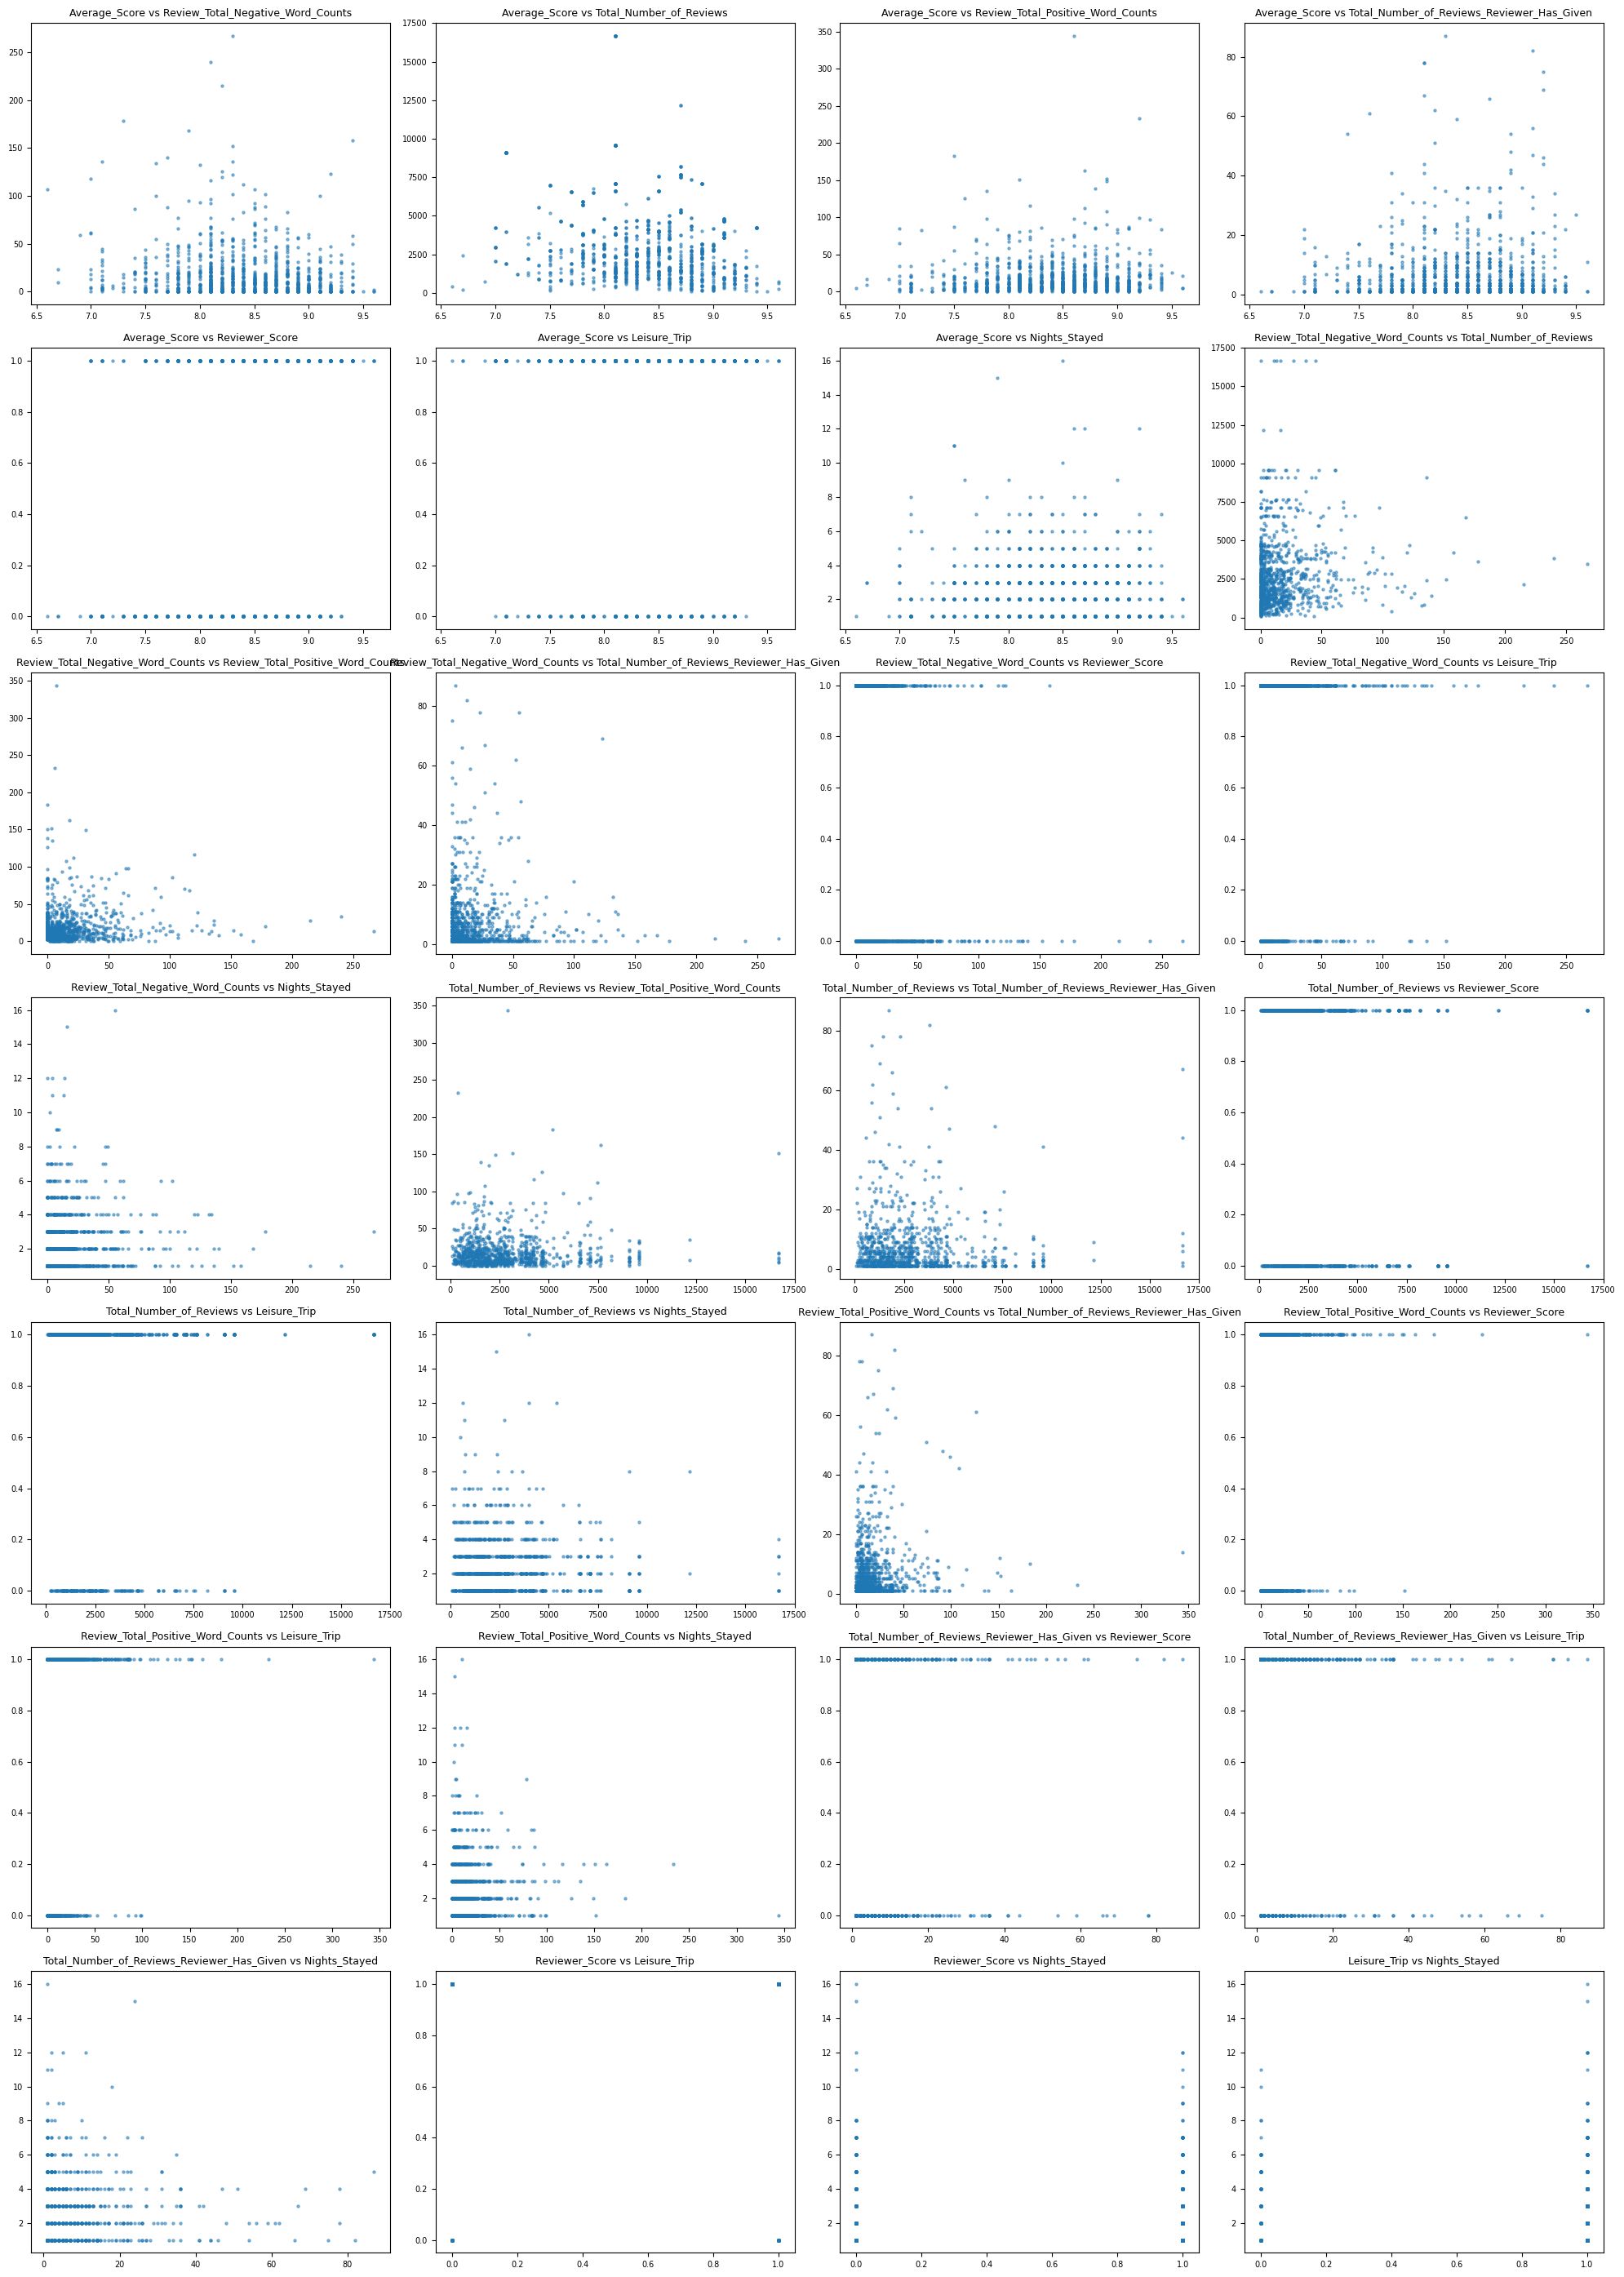

In [19]:
# Examine scatter plots comparing numeric columns, checking for correlation

scatter_cols = ['Average_Score', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'Leisure_Trip', 'Nights_Stayed']

scatter_df = hotel_df[scatter_cols]


scatter_matrix(scatter_df)

ADD NOTES ABOUT SCATTER PLOTS

In [20]:
# Examine correlation heatmap for numeric columns

gen_corr_heatmap(hotel_df)

INSERT NOTES ABOUT CORRELATION

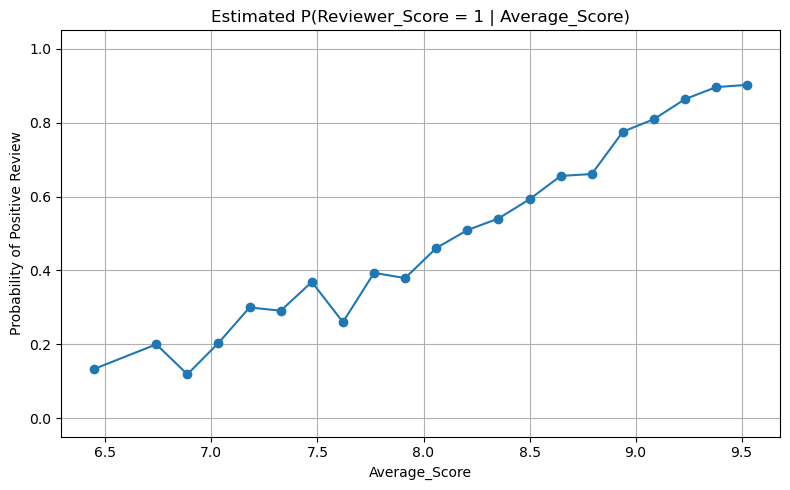

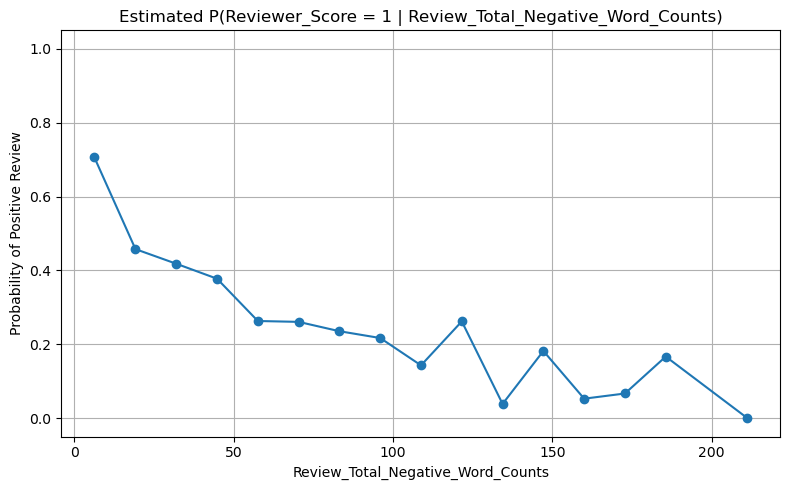

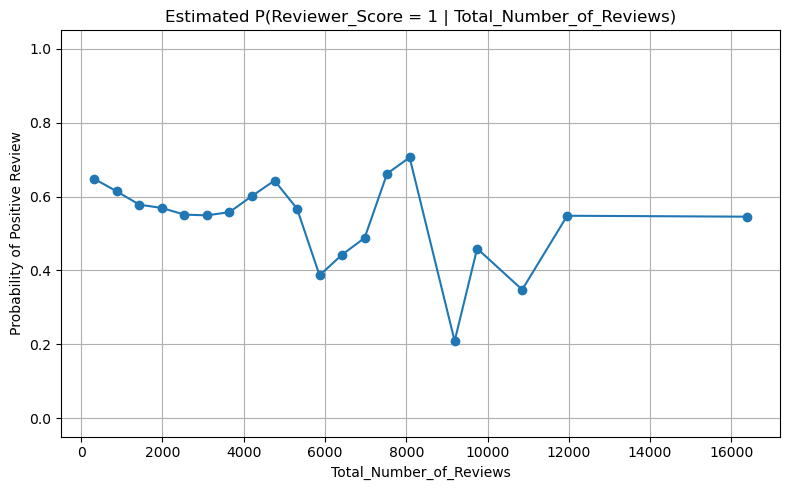

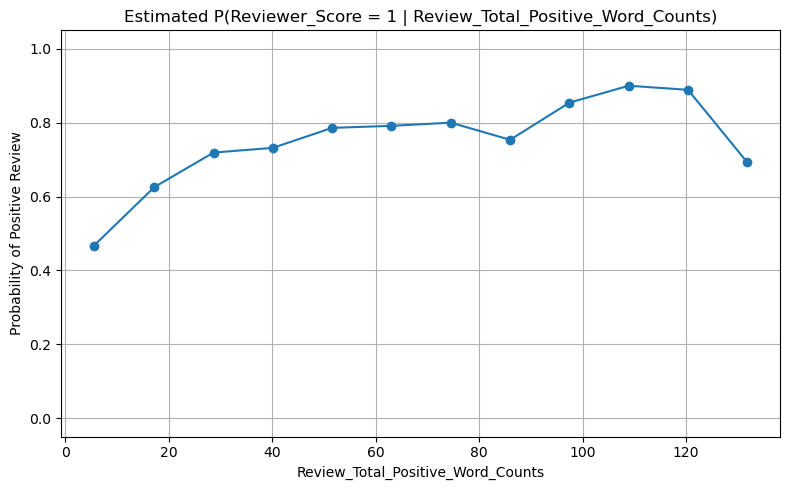

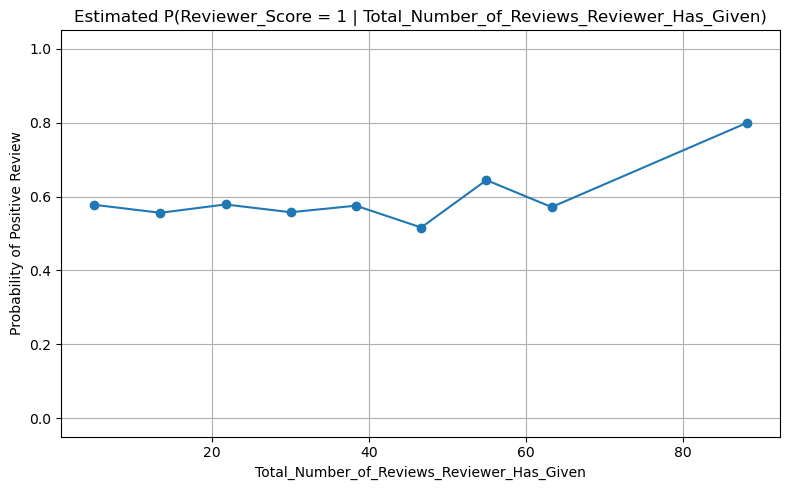

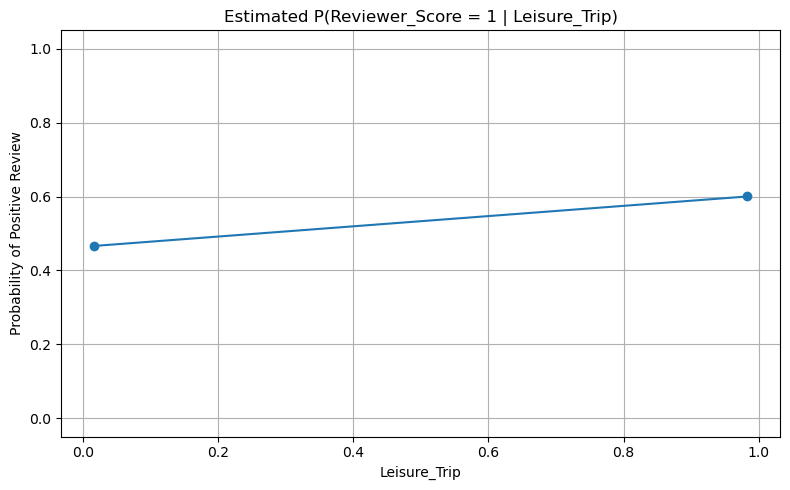

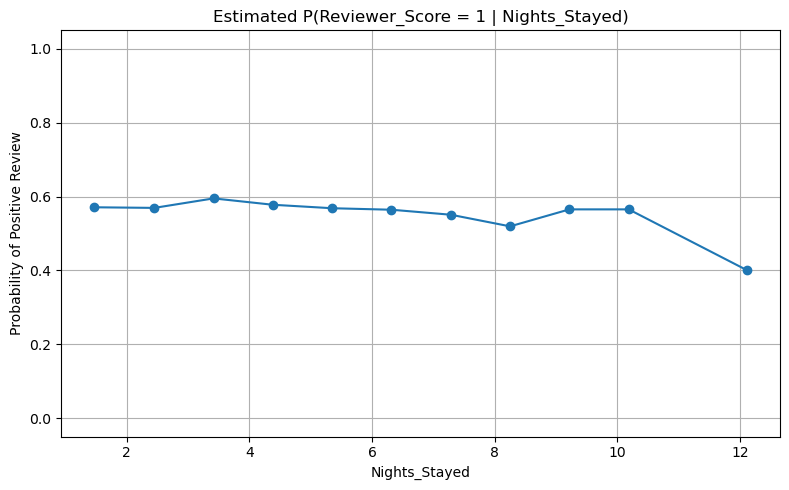

In [21]:
# Plot probability of a positive review vs. various quantitative features

prob_cols = ['Average_Score', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given',
       'Leisure_Trip', 'Nights_Stayed']

for col in prob_cols:
    plot_pos_probability(hotel_df, col)

INSERT NOTES ABOUT PROB PLOTS

In [22]:
# Examine basic statistical info about the cleaned datafraame
hotel_df.describe()

,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Latitude,Longitude,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,...,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed,Review_month_sin,Review_month_cos
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,5.157380e+05,5.157380e+05
mean,8.397487,18.539450,2743.743944,17.776458,7.166001,0.570006,49.432419,2.893479,0.042048,0.028749,...,0.110936,0.116627,0.508594,0.072143,0.116199,0.075502,0.810059,2.362122,-2.157438e-02,-4.707311e-02
std,0.548048,29.690831,2317.464868,21.804185,11.040228,0.495075,3.460237,4.667477,0.200700,0.167101,...,0.314053,0.320976,0.499927,0.258725,0.320463,0.264199,0.392255,1.646808,7.081175e-01,7.041947e-01
min,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000e+00,-1.000000e+00
25%,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,48.214066,-0.143372,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-8.660254e-01,-8.660254e-01
50%,8.400000,9.000000,2134.000000,11.000000,3.000000,1.000000,51.499981,0.019886,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,-2.449294e-16,-1.836970e-16
75%,8.800000,23.000000,3613.000000,22.000000,8.000000,1.000000,51.516288,4.841163,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000e-01,5.000000e-01
max,9.800000,408.000000,16670.000000,395.000000,355.000000,1.000000,52.400181,16.429233,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000,1.000000e+00,1.000000e+00


## 1.4 Data Dictionary

In [10]:
# Examine the cleaned dataframe
examine_df(hotel_df)



Number of records is: 515738

The columns are: Index(['Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Positive_Review', 'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'Latitude', 'Longitude', 'Reviewer_Nationality_Australia',
       'Reviewer_Nationality_Ireland', 'Reviewer_Nationality_UAE',
       'Reviewer_Nationality_UK', 'Reviewer_Nationality_USA',
       'Reviewer_Nationality_Other', 'Hotel_Address_Amsterdam',
       'Hotel_Address_Barcelona', 'Hotel_Address_London',
       'Hotel_Address_Milan', 'Hotel_Address_Paris', 'Hotel_Address_Vienna',
       'Leisure_Trip', 'Nights_Stayed'],
      dtype='object')


 General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Negative_Review 

None


 Statistical info:


,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Latitude,Longitude,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,18.539450,17.776458,7.166001,0.570006,49.432419,2.893479,0.042048,0.028749,0.019845,0.475524,0.068711,0.365121,0.110936,0.116627,0.508594,0.072143,0.116199,0.075502,0.810059,2.362122
std,29.690831,21.804185,11.040228,0.495075,3.460237,4.667477,0.200700,0.167101,0.139469,0.499401,0.252963,0.481465,0.314053,0.320976,0.499927,0.258725,0.320463,0.264199,0.392255,1.646808
min,0.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,5.000000,1.000000,0.000000,48.214066,-0.143372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,9.000000,11.000000,3.000000,1.000000,51.499981,0.019886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,23.000000,22.000000,8.000000,1.000000,51.516288,4.841163,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,408.000000,395.000000,355.000000,1.000000,52.400181,16.429233,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000




Sample of records:


,Negative_Review,Review_Total_Negative_Word_Counts,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Latitude,Longitude,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
0,I am so angry that i made this post available...,397,Only the park outside of the hotel was beauti...,11,7,0,52.360576,4.915968,0,0,...,0,1,1,0,0,0,0,0,1,6
1,No Negative,0,No real complaints the hotel was great great ...,105,7,0,52.360576,4.915968,0,1,...,0,0,1,0,0,0,0,0,1,4
2,Rooms are nice but for elderly a bit difficul...,42,Location was good and staff were ok It is cut...,21,9,0,52.360576,4.915968,1,0,...,0,0,1,0,0,0,0,0,1,3
3,My room was dirty and I was afraid to walk ba...,210,Great location in nice surroundings the bar a...,26,1,0,52.360576,4.915968,0,0,...,0,0,1,0,0,0,0,0,1,3
4,You When I booked with your company on line y...,140,Amazing location and building Romantic setting,8,3,0,52.360576,4.915968,0,0,...,0,1,1,0,0,0,0,0,1,2


<table> <tr> <th style="text-align: left; background: darkgrey">Column Name</th> <th style="text-align: left; background: darkgrey">Column Contents</th> <th style="text-align: left; background: darkgrey">Data Type</th> </tr> 
    <!-- <tr> <td style="text-align: left"><code>Average_Score</code></td> <td style="text-align: left">Average score of the hotel, calculated based on the latest reviews in the last year</td> <td style="text-align: left">float</td> </tr>  -->
    <tr> <td style="text-align: left"><code>Negative_Review</code></td> <td style="text-align: left">Text of the negative review; 'No Negative' if not provided</td> <td style="text-align: left">string</td> </tr> 
    <tr> <td style="text-align: left"><code>Review_Total_Negative_Word_Counts</code></td> <td style="text-align: left">Number of words in the negative review</td> <td style="text-align: left">integer</td> </tr> 
    <!-- <tr> <td style="text-align: left"><code>Total_Number_of_Reviews</code></td> <td style="text-align: left">Total number of valid reviews received by the hotel</td> <td style="text-align: left">integer</td> </tr>  -->
    <tr> <td style="text-align: left"><code>Positive_Review</code></td> <td style="text-align: left">Text of the positive review; 'No Positive' if not provided</td> <td style="text-align: left">string</td> </tr> 
    <tr> <td style="text-align: left"><code>Review_Total_Positive_Word_Counts</code></td> <td style="text-align: left">Number of words in the positive review</td> <td style="text-align: left">integer</td> </tr> <tr> <td style="text-align: left"><code>Total_Number_of_Reviews_Reviewer_Has_Given</code></td> <td style="text-align: left">Total number of reviews the reviewer has submitted on the platform</td> <td style="text-align: left">integer</td> </tr> <tr> <td style="text-align: left"><code>Reviewer_Score</code></td> <td style="text-align: left">Positive (1) or negative (0) sentiment given by the reviewer for the hotel stay</td> <td style="text-align: left">integer (binary)</td> </tr> <tr> <td style="text-align: left"><code>Latitude</code></td> <td style="text-align: left">Latitude of the hotel location</td> <td style="text-align: left">float</td> </tr> <tr> <td style="text-align: left"><code>Longitude</code></td> <td style="text-align: left">Longitude of the hotel location</td> <td style="text-align: left">float</td> </tr> <tr> <td style="text-align: left"><code>Reviewer_Nationality</code></td> <td style="text-align: left">Binary indicator columns showing if the reviewer is from Australia, Ireland, UAE, UK, USA, or Other</td> <td style="text-align: left">integer (binary)</td> </tr> <tr> <td style="text-align: left"><code>Hotel_Address_City</code></td> <td style="text-align: left">Binary indicator columns showing if the hotel is in Amsterdam, Barcelona, London, Milan, Paris, or Vienna</td> <td style="text-align: left">integer (binary)</td> </tr> <tr> <td style="text-align: left"><code>Leisure_Trip</code></td> <td style="text-align: left">Binary indicator for whether the trip was for leisure (vs business)</td> <td style="text-align: left">integer (binary)</td> </tr> <tr> <td style="text-align: left"><code>Nights_Stayed</code></td> <td style="text-align: left">Number of nights the guest stayed at the hotel</td> <td style="text-align: left">integer</td> </tr> <tr> <td style="text-align: left"><code>Review_month_sin</code></td> <td style="text-align: left">Sine-transformed month of the review date to capture cyclic seasonality</td> <td style="text-align: left">float</td> </tr> <tr> <td style="text-align: left"><code>Review_month_cos</code></td> <td style="text-align: left">Cosine-transformed month of the review date to capture cyclic seasonality</td> <td style="text-align: left">float</td> </tr> </table>

# 2. Preprocessing

INSERT INTRO TO THIS SECTION

## 2.1 Train and Test Split

INTRODUCE THIS SECTION

In [11]:
# Split into features and target

y = hotel_df['Reviewer_Score']   # Target variable
X = hotel_df.drop(columns=['Reviewer_Score'])  # Drop target from features

In [12]:
# Splitting our data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2025)

In [13]:
# Check shapes

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (345544, 21)
X_test shape: (170194, 21)
y_train shape: (345544,)
y_test shape: (170194,)


## 2.2 Define Text Cleaning and CountVectorizer Pipeline

INTRODUCE THIS SECTION

In [14]:
# Define function to clean and process text then return list of tokens (unigrams and bigrams)

def clean_tokenizer(text):

    """
    Given a text object, execute basic text cleaning (lowercase, remove punctuation, and stop words) then return list of unigrams and bigrams
    """
    
    # Lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize by whitespace
    tokens = text.split()
    # Remove stopwords
    tokens = [token for token in tokens if token not in ENGLISH_STOP_WORDS]
    
    # Generate bigrams
    bigrams = [f"{tokens[i]}_{tokens[i+1]}" for i in range(len(tokens)-1)]
    
    # Return combined list of unigrams and bigrams
    return tokens + bigrams

In [15]:
# Define CountVectorizers for positive and negative reviews

# Define vectorizer for positive reviews
pos_vectorizer = CountVectorizer(
    tokenizer=clean_tokenizer,
    max_features=500,
    min_df=10
)

# Define vectorizer for negative reviews
neg_vectorizer = CountVectorizer(
    tokenizer=clean_tokenizer,
    max_features=500,
    min_df=10
)


## 2.3 Apply CountVectorizer Pipeline to Data

INTRODUCE SECTION

In [16]:
# Apply positive review vectorizer to train and test sets

# Fit on training data and transform train and test sets
X_train_pos = pos_vectorizer.fit_transform(X_train["Positive_Review"])
X_test_pos = pos_vectorizer.transform(X_test["Positive_Review"])

# Add 'pos_' prefix to feature names
pos_feature_names = [f"pos_{word}" for word in pos_vectorizer.get_feature_names_out()]

C:\Users\emshe\anaconda3\envs\ml_env\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [17]:
# Apply negative review vectorizer to train and test sets

# Fit on training data and transform train and test sets
X_train_neg = neg_vectorizer.fit_transform(X_train["Negative_Review"])
X_test_neg = neg_vectorizer.transform(X_test["Negative_Review"])

# Add 'neg_' prefix to feature names
neg_feature_names = [f"neg_{word}" for word in neg_vectorizer.get_feature_names_out()]

In [18]:
# Drop text columns from train and test sets

X_train_numeric = X_train.drop(columns=["Positive_Review", "Negative_Review"])
X_test_numeric = X_test.drop(columns=["Positive_Review", "Negative_Review"])

In [19]:
# Combine numeric columns and token columns to obtain single train and test dataframes

# Convert token arrays to dataframes
X_train_pos_df = pd.DataFrame(X_train_pos.toarray(), columns=pos_feature_names, index=X_train.index)
X_test_pos_df = pd.DataFrame(X_test_pos.toarray(), columns=pos_feature_names, index=X_test.index)

X_train_neg_df = pd.DataFrame(X_train_neg.toarray(), columns=neg_feature_names, index=X_train.index)
X_test_neg_df = pd.DataFrame(X_test_neg.toarray(), columns=neg_feature_names, index=X_test.index)




# Combine all features

X_train_final = pd.concat([X_train_numeric, X_train_pos_df, X_train_neg_df], axis=1)
X_test_final = pd.concat([X_test_numeric, X_test_pos_df, X_test_neg_df], axis=1)

In [20]:
# Check shapes of train and test sets

print("Final training set shape:", X_train_final.shape)
print("Final test set shape:", X_test_final.shape)

Final training set shape: (345544, 1019)
Final test set shape: (170194, 1019)


In [21]:
# Examine train test with token features

examine_df(X_train_final)



Number of records is: 345544

The columns are: Index(['Review_Total_Negative_Word_Counts',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Latitude', 'Longitude',
       'Reviewer_Nationality_Australia', 'Reviewer_Nationality_Ireland',
       'Reviewer_Nationality_UAE', 'Reviewer_Nationality_UK',
       'Reviewer_Nationality_USA',
       ...
       'neg_window', 'neg_windows', 'neg_work', 'neg_working', 'neg_worn',
       'neg_worst', 'neg_worth', 'neg_wouldn', 'neg_wouldn_t', 'neg_wrong'],
      dtype='object', length=1019)


 General info:
<class 'pandas.core.frame.DataFrame'>
Index: 345544 entries, 453092 to 481854
Columns: 1019 entries, Review_Total_Negative_Word_Counts to neg_wrong
dtypes: float64(2), int64(1017)
memory usage: 2.6 GB


None


 Statistical info:


,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Latitude,Longitude,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,...,neg_window,neg_windows,neg_work,neg_working,neg_worn,neg_worst,neg_worth,neg_wouldn,neg_wouldn_t,neg_wrong
count,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,...,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000
mean,18.544015,17.779999,7.167035,49.433937,2.892558,0.042096,0.028714,0.020058,0.476090,0.068145,...,0.018603,0.011200,0.025212,0.014661,0.003299,0.003878,0.006103,0.005342,0.005339,0.004170
std,29.720430,21.819394,11.062218,3.457388,4.669700,0.200808,0.167002,0.140200,0.499429,0.251994,...,0.149456,0.111198,0.170052,0.128568,0.059620,0.064618,0.079613,0.075891,0.075872,0.068492
min,0.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,1.000000,48.214277,-0.143372,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,11.000000,3.000000,51.499981,0.019886,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23.000000,22.000000,8.000000,51.516288,4.834975,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,408.000000,386.000000,355.000000,52.400181,16.429233,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,3.000000,6.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000




Sample of records:


,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Latitude,Longitude,Reviewer_Nationality_Australia,Reviewer_Nationality_Ireland,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,...,neg_window,neg_windows,neg_work,neg_working,neg_worn,neg_worst,neg_worth,neg_wouldn,neg_wouldn_t,neg_wrong
453092,22,0,2,52.378682,4.820783,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35829,62,5,10,51.494552,-0.186121,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
339369,26,8,3,52.357655,4.844576,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499205,19,17,45,41.385378,2.156723,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492963,0,8,1,45.500025,9.142872,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


INSERT ANALYSIS HERE

# 3. Modelling

INTRODUCE SECTION

## 3.1 Logistic Regression Classifier

QUESTION: Fit a logistic regression model on the data and analyze the test and train accuracy. Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1). Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0). What actionable insights can you draw from these?

### 3.1.1 Construct Logistic Regression Pipeline

In [22]:
# Define logistic regression pipeline with scaling and ridge regularization

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty='l2',       # Ridge regularization
        C=1.0,
        solver='liblinear',
        max_iter=1000
    ))
])

In [23]:
# Define function to evaluate logistic regression model

def evaluate_log_reg_model(y_true, y_pred,dataset_name = ""):
    
    """
    Evaluate logistic regression model on test set using accuracy, precision, recall, and F1 scores
    """
    
    print(f"Evaluation on {dataset_name} set:")
    print(f"Accuracy  : {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision : {precision_score(y_true, y_pred):.3f}")
    print(f"Recall    : {recall_score(y_true, y_pred):.3f}")
    print(f"F1 Score  : {f1_score(y_true, y_pred):.3f}")
    print()


### 3.1.2 Fit and Evaluate Logistic Regression Model

In [ ]:
# Fit model to train set

pipeline.fit(X_train_final, y_train)

In [42]:
# Check evaluation metrics for train and test sets

# Predictions
y_train_pred = pipeline.predict(X_train_final)
y_test_pred = pipeline.predict(X_test_final)

# Evaluate
evaluate_log_reg_model(y_train, y_train_pred,"train set")
evaluate_log_reg_model(y_test, y_test_pred,"test set")

📊 Evaluation on train set set:
Accuracy  : 0.791
Precision : 0.801
Recall    : 0.842
F1 Score  : 0.821

📊 Evaluation on test set set:
Accuracy  : 0.789
Precision : 0.799
Recall    : 0.841
F1 Score  : 0.820



In [43]:
# Get feature names from X_train_final
feature_names = X_train_final.columns

# Get the fitted model from the pipeline
log_reg = pipeline.named_steps['clf']

# Extract the coefficients (as a flat array)
coefficients = log_reg.coef_.flatten()

# Combine into a DataFrame
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# Sort by absolute value of coefficient
top_20_features = coef_df.sort_values(by='abs_coefficient', ascending=False).head(20)

# Display
top_20_features[['feature', 'coefficient']]

,feature,coefficient
0,Average_Score,0.543709
5,Latitude,0.326700
142,pos_didn_t,-0.320049
614,neg_couldn,-0.316729
615,neg_couldn_t,0.315920
141,pos_didn,0.314715
6,Longitude,-0.286587
645,neg_doesn,-0.267706
1,Review_Total_Negative_Word_Counts,-0.267525
636,neg_didn_t,-0.265202


## 3.2 Decision Tree Classifier

# Conclusion